# Import Necessary Libraries

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np

# Import the Dataset

In [2]:
df = pd.read_csv('spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

We have an imbalanced dataset here.

In [4]:
df["Category"].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

%13 percent spam and %87 percent non-spam.

In [7]:
747/(4825+747)

0.13406317300789664

We can use down-sampling method to balance the dataset. What we do is we randomly select non-spam samples of the same size as spam samples.

In [9]:
df_spam = df[df["Category"] == "spam"]
df_spam.shape

(747, 2)

In [10]:
df_ham = df[df["Category"] == "ham"]
df_ham.shape

(4825, 2)

In [12]:
df_ham_selected = df_ham.sample(df_spam.shape[0])
df_ham_selected.shape

(747, 2)

In [13]:
df_balanced = pd.concat([df_ham_selected, df_spam])

In [14]:
df_balanced["Category"].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [16]:
# Create a new column with 0 for ham and 1 for spam
df_balanced["spam"] = df_balanced["Category"].apply(lambda x: 1 if x=="spam" else 0)
df_balanced.sample(5)

,Category,Message,spam
717,spam,#ERROR!,1
2493,ham,No drama Pls.i have had enough from you and fa...,0
5322,ham,"Thanks, I'll keep that in mind",0
3493,ham,I will reach office around &lt;DECIMAL&gt; . ...,0
427,ham,aathi..where are you dear..,0


# Train/Test Split

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced["Message"], df_balanced["spam"], stratify=df_balanced["spam"], random_state=0)

In [18]:
X_train.head()

316                            K.k:)advance happy pongal.
4899         Oh for fuck's sake she's in like tallahassee
3421    As a valued customer, I am pleased to advise y...
3237    Aight text me when you're back at mu and I'll ...
1216    that would be good … I'll phone you tomo lunch...
Name: Message, dtype: object

# Import Pre-Trained BERT Model

In [19]:
preproces_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [20]:
preprocess_model = hub.KerasLayer(preproces_url)
encoder_model = hub.KerasLayer(encoder_url)

In [21]:
def get_sentence_embeddings(sentences):
    preprocessed_sentences = preprocess_model(sentences)
    return encoder_model(preprocessed_sentences)["pooled_output"]

Let's see how these embeddings actually helps us with an example.

In [22]:
e = get_sentence_embeddings([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
])

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

print("Cosine similarity between banana and grapes: ", cosine_similarity([e[0]], [e[1]]))

Cosine similarity between banana and grapes:  [[0.9911088]]


In [25]:
print("Cosine similarity between banana and Jeff Bezos: ", cosine_similarity([e[0]], [e[3]]))

Cosine similarity between banana and Jeff Bezos:  [[0.8470384]]


In [26]:
print("Cosine similarity between Jeff Bezos and Elon Musk: ", cosine_similarity([e[3]], [e[4]]))

Cosine similarity between Jeff Bezos and Elon Musk:  [[0.98720354]]


# Build the Model

In [27]:
# Bert Layers to get the embeddings of the sentences to be used in the classification task
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="Input_Layer")
preprocessed_text = preprocess_model(text_input)
encoder_outputs = encoder_model(preprocessed_text)

# Classification layer
embeddings_dropout = tf.keras.layers.Dropout(0.1, name="Dropout_Layer")(encoder_outputs["pooled_output"])
class_output = tf.keras.layers.Dense(1, activation="sigmoid", name="Output_Layer")(embeddings_dropout)

# Create the model
model = tf.keras.Model(inputs = [text_input], outputs = [class_output])

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Layer (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['Input_Layer[0][0]']            
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [29]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall")
]

model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=METRICS)

In [30]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 244s 6s/step - loss: 0.5819 - accuracy: 0.7330 - precision: 0.7430 - recall: 0.7125
Epoch 2/10
35/35 [==============================] - 230s 7s/step - loss: 0.4786 - accuracy: 0.8429 - precision: 0.8322 - recall: 0.8589
Epoch 3/10
35/35 [==============================] - 221s 6s/step - loss: 0.4234 - accuracy: 0.8491 - precision: 0.8319 - recall: 0.8750
Epoch 4/10
35/35 [==============================] - 230s 7s/step - loss: 0.3868 - accuracy: 0.8705 - precision: 0.8523 - recall: 0.8964
Epoch 5/10
35/35 [==============================] - 218s 6s/step - loss: 0.3587 - accuracy: 0.8705 - precision: 0.8609 - recall: 0.8839
Epoch 6/10
35/35 [==============================] - 220s 6s/step - loss: 0.3447 - accuracy: 0.8759 - precision: 0.8766 - recall: 0.8750
Epoch 7/10
35/35 [==============================] - 218s 6s/step - loss: 0.3265 - accuracy: 0.8857 - precision: 0.8816 - recall: 0.8911
Epoch 8/10
35/35 [==============================

In [31]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 74s 6s/step - loss: 0.2350 - accuracy: 0.9225 - precision: 0.9158 - recall: 0.9305


[0.23502735793590546,
 0.9224599003791809,
 0.9157894849777222,
 0.9304812550544739]

In [32]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

12/12 [==============================] - 81s 7s/step


In [33]:
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred[:10]

array([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,

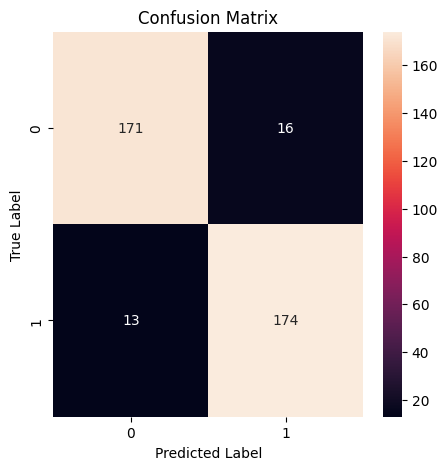

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [36]:
# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       187
           1       0.92      0.93      0.92       187

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374



# Inference

In [37]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.73804444],
       [0.86099285],
       [0.80741787],
       [0.18186294],
       [0.10559573]], dtype=float32)